## PDF to HTML

In [ ]:
%%time
# PDF to HTML
# https://sourceforge.net/projects/pdftohtml/
# https://www.experts-exchange.com/videos/59892/Xpdf-PDFtoHTML-Command-Line-Utility-to-Convert-a-PDF-File-to-HTML.html
# https://www.xpdfreader.com/download.html

# make sure to have a folder named "pdf_files" with the pdfs
# make sure to have an empty folder named "html_files"
import os
echo = "pdftohtml"
for filename in os.listdir("pdf_files"):
    if filename.endswith("pdf"):
        #print(filename)
        file_pdf = "pdf_files/" + filename
        file_html = "html_files/" + filename
        #os.system(echo+" "+file_pdf+" "+file_html) 

## creates table of features

In [1]:
import codecs
from bs4 import BeautifulSoup
import cssutils
import pandas as pd
import os

In [2]:
def style_dict(style_tem):
    '''
    stores features in a dictionary 
    '''
    style_tem = style_tem[:-1]
    style_dic = dict(item.split(":") for item in style_tem.split(";"))
    return style_dic

def css_style(soup):
    '''
    reads information from css in html
    '''
    selectors = {}
    for styles in soup.select('style'):
        css = cssutils.parseString(styles.encode_contents())
        for rule in css:
            if rule.type == rule.STYLE_RULE:
                style = rule.selectorText
                selectors[style] = {}
                for item in rule.style:
                    propertyname = item.name
                    value = item.value
                    selectors[style][propertyname] = value

    dict_css = {key.strip('#'): item for key, item in selectors.items()}
    return dict_css

def extract_features(path):
    '''
    Extract all the features from html files
    '''
    with open(path) as raw_resuls:
        results = BeautifulSoup(raw_resuls, 'lxml')
    
    dict_css = css_style(results)
    lines = []
    text = []
    for element in results.find_all("body"):
        for stat in element.find_all("div"):
            data={}
            # gets the info from <div>
            div_dic = stat.attrs
            data.update(div_dic)

            # gets info from <span>
            span_dic = stat.find('span').attrs
            data.update(span_dic)

            # gets the features from style in <div> "USING SPAN"
            style_ = span_dic.get('style')
            style_span = style_dict(style_)
            data.update(style_span)

            # gets features of the font from css 
            font = span_dic.get('id')
            temp = dict_css.get(font)
            data.update(temp)

            # gets the features from style in <div> "USING DIV"
            style_ = div_dic.get('style')
            style_temp = style_dict(style_)
            #print(style_temp)
            data.update(style_temp)
            
            d = pd.DataFrame.from_dict(data)
            
            text.append(stat.text)
            lines.append(d)

    dataframe = pd.concat(lines, axis=0).reset_index(drop=1)
    dataframe["text"] = pd.Series( (v for v in text))
    
    return dataframe

In [59]:
def is_date(string):
    try: 
        parse(string)
        return True
    except ValueError:
        return False
    
def color_match(x):
    '''
    finds the color of the font
    '''
    def closest_color(requested_color):
        #from stackoverflow function
        min_colors = {}
        for key, name in webcolors.css3_hex_to_names.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_color[0]) ** 2
            gd = (g_c - requested_color[1]) ** 2
            bd = (b_c - requested_color[2]) ** 2
            min_colors[(rd + gd + bd)] = name
        return min_colors[min(min_colors.keys())]
    
    temp = re.sub("[r\rgba\()]", '', x)
    c = [int(s) for s in temp.split(',') if s.isdigit()]
    requested_color = (c[0],c[1],c[2])
    color_name = closest_color(requested_color)
    return color_name

def find_ngrams(input_list, n):
    '''
    find ngrams of each line
    '''
    ngrams = list(zip(*[input_list[i:] for i in range(n)]))
    try:
        ngrams = str(ngrams[0])
        ngrams = re.sub(r'[^\w\s]+', '',ngrams)
    except:
        ngrams = np.nan
    return ngrams

def most_freq(df):
    '''
    input : dataframe
    Returns the linespace most frequent. This can help us identify paragraphs and titles.
    '''
    freq_LST = df[["document","page",
                         "LST"]].groupby(["document","page","LST"])["LST"].count().reset_index(name='count')
    freq_LST = freq_LST.groupby(["document","page"])["count"].max().reset_index(name='freq_LST')
    
    freq_FS = df[["document","page",
                         "font-size"]].groupby(["document","page","font-size"])["font-size"].count().reset_index(name='count')
    freq_FS = freq_FS.groupby(["document","page"])["count"].max().reset_index(name='freq_font_size')
    
    freq_RS = df[["document","page",
                         'num_letters']].groupby(["document","page"])["num_letters"].mean().reset_index(name='count')
    freq_RS = freq_RS.groupby(["document","page"])["count"].max().reset_index(name='freq_row_size')

    data_frames = [freq_LST,freq_FS,freq_RS]
    freq  = reduce(lambda  left,right: pd.merge(left,right,on=["document","page"],
                                            how='outer'), data_frames)
    return freq


def section_ids(df):
    ''' 
    input data frame with the following columns document, page, Class
    this will extract the section if once the row is tagged
    '''
    
    secID_in = []
    for doc in df["document"].unique():
        temp = df[df["document"]==doc]
        j = 1
        for i in range(len(temp)):
            if temp.iloc[i,2] == 1.0:
                secID_in.append((temp.iloc[i,0],temp.iloc[i,1],temp.iloc[i,2],j))
                j+=1
            elif temp.iloc[i,2] == 0.0:
                secID_in.append((temp.iloc[i,0],temp.iloc[i,1],temp.iloc[i,2],0))
            else:
                secID_in.append((temp.iloc[i,0],temp.iloc[i,1],temp.iloc[i,2],np.nan))

    id1 = pd.DataFrame(secID_in, columns =["document","page","Class","secIDin"])

    secID_all = []
    j = 1
    for i in range(len(df)):
        if df.iloc[i,2] == 1.0:
            secID_all.append((df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],j))
            j+=1
        elif df.iloc[i,2] == 0.0:
            secID_all.append((df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],0))
        else:
            secID_all.append((df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],np.nan))

    id2 = pd.DataFrame(secID_all, columns =["document","page","Class","secIDall"])  

    sections = pd.merge(id1, id2,left_index=True, right_index=True, on=["document","page","Class"])
    return sections


def one_hot(df,colname):
    '''
    This is going to change change categorical values into binary values
    '''
    # Get one hot encoding of columns 'font-family'
    one_hot = pd.get_dummies(df[colname],prefix=colname)
    # Drop column B as it is now encoded
    df = df.drop(colname,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

def one_hot_col(dataframe):
    '''
    One hot encode all the columns we want to cover to binary
    '''
    for col in dataframe.columns:
        dataframe = one_hot(dataframe, col)
    return dataframe


def cleans_original(features):
    '''
    input: list of "features" coming from pdf-html converter
    output: clean dataframe 
    '''
    original = pd.concat(features, axis=0, sort=False).reset_index(drop=1)
    #removes columns that only have one unique value
    columns = original.columns[original.nunique()>1]
    original = original[columns]
    #remove style and id columns because are not relevant (these are just classes from html)
    original = original.drop(["style","id"], axis=1)
    #remove whitespace in names of the columns
    original.columns = original.columns.str.replace(' ', '')
    # color name
    original["color"] = original["color"].apply(lambda x: color_match(x))
    #Leading_Char_Upper = LCU
    original["LCU"]=original['text'].str[0].str.isupper().map({True: '1', False: '0'})
    #Leading_Numeral
    original["LN"] = original['text'].str[0].str.isdigit().map({True: '1', False: '0'})
    #Ends_In_Period
    original["EIP"]= original['text'].str.endswith(".").map({True: '1', False: '0'})
    #Leading_Number_Period. Check start with any nuerical combinations followed by ".", ex 1.
    original['LNP'] = original['text'].str.match("\d+\..*").map({True: '1', False: '0'})
    #'Leading_Char_Period'. Check start with any uppercase or lowercase character  followed by "." , ex A.
    original["LCP"] =original['text'].str.contains('^[A-Z,a-z]\.+').map({True: '1', False: '0'})
    # Roman_Period. Any roman numaral  followed by "."
    original["RP"] = original['text'].str.contains('[V|I|X]\.+').map({True: '1', False: '0'})
    # number of words in a row
    original["num_words"] = original["text"].apply(lambda x: len(x.split()))
    # number of letters in a row
    original["num_letters"] = original["text"].apply(lambda x: len(x))
    #Clean px and convert to right data type for columns: fontsize, left and top
    original['font-size'] = pd.to_numeric(original['font-size'].str.replace('px', ''))
    original['left'] = pd.to_numeric(original['left'].str.replace('px', ''))
    original['top'] = pd.to_numeric(original['top'].str.replace('px', ''))
    # convert page number to int
    original["page"] = original["page"].apply(lambda x: int(''.join(filter(str.isdigit, x))))
    # clean page name
    original["document"] = original["document"].apply(lambda x: x.split("/")[-1])
    # find ngrams
    original['trigrams'] = original['text'].map(lambda x: find_ngrams(x.split(" "), 3))
    #first word
    original["first_word"] = original["text"].apply(lambda x: x.split(' ', 1)[0])
    # checks if first word is a data
    original["isDate"] = original["first_word"].apply(lambda x: is_date(x))
    # line space between rows (top)
    original["LST"] = original.groupby(["document","page"])["top"].apply(lambda x: x.diff())
    # line space between rows (left)
    original["LSL"] = original.groupby(["document","page"])["left"].apply(lambda x: x.diff())
    # line per page
    original["LPG"]=original.groupby(['document','page']).cumcount()+1
    # line per document 
    original["LPD"] = original.groupby(['document']).cumcount()+1
    return original 

### reads all html files

In [4]:
import re 
import webcolors
import numpy as np
import pandas as pd
import os
from functools import reduce
from dateutil.parser import parse
from fuzzywuzzy import process

/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
%time
features = []
for root, dirs, files in os.walk("html_files"):
    for file in files:
        if file.endswith(".html"):
            if file != "index.html":
                try:
                    file_path =  os.path.join(root, file)
                    #print(file_path+ " found")
                    df = extract_features(file_path)
                    df = df.assign(page=file)
                    df = df.assign(document=root)
                    features.append(df)
                except:
                    print(file_path+" NOT found")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



html_files/CMS_2014_0115_13244.pdf/page7.html NOT found
html_files/CMS_2014_0115_58105.pdf/page8.html NOT found


In [60]:
%%time 
original=cleans_original(features)

CPU times: user 1min 13s, sys: 756 ms, total: 1min 14s
Wall time: 1min 15s


In [61]:
print(original.shape)
print(original.columns)

(41910, 26)
Index(['font-size', 'vertical-align', 'color', 'font-family', 'font-weight',
       'font-style', 'left', 'top', 'text', 'page', 'document', 'LCU', 'LN',
       'EIP', 'LNP', 'LCP', 'RP', 'num_words', 'num_letters', 'trigrams',
       'first_word', 'isDate', 'LST', 'LSL', 'LPG', 'LPD'],
      dtype='object')


### Read DataFrame with Tagged Values

In [62]:
# name, Section_Id_Document, Section_ID, Paragraph, Comment, Class, df_idx
colnames = ["document","page","Section_Id_Document", "Section_ID", "Paragraph", "Comment", "Class", "df_idx","Name"]
excel_file = pd.read_excel('./features.xlsx', sheet_name = 'features_v7' , 
                           header=1, skip_blank_lines = False) 
excel_file["page"] = excel_file["page"].apply(lambda x: int(''.join(filter(str.isdigit, x))))
excel_file["document"] = excel_file["document"].apply(lambda x: x.split("/")[-1])

In [63]:
# merge tagged data with data
data = pd.merge(original,excel_file[colnames],left_index=True, right_index=True, on=["document","page"])

In [64]:
print(data.shape)
print(data.columns)

(41910, 33)
Index(['font-size', 'vertical-align', 'color', 'font-family', 'font-weight',
       'font-style', 'left', 'top', 'text', 'page', 'document', 'LCU', 'LN',
       'EIP', 'LNP', 'LCP', 'RP', 'num_words', 'num_letters', 'trigrams',
       'first_word', 'isDate', 'LST', 'LSL', 'LPG', 'LPD',
       'Section_Id_Document', 'Section_ID', 'Paragraph', 'Comment', 'Class',
       'df_idx', 'Name'],
      dtype='object')


In [65]:
%%time
# gets sections 
sec_doc = section_ids(data[["document", "page", "Class"]])
print(sec_doc.shape)
print(data.shape)
data = pd.merge(data,sec_doc,left_index=True, right_index=True, on=["document","page", "Class"])
print(data.shape)

(41910, 5)
(41910, 33)
(41910, 35)
CPU times: user 5.09 s, sys: 71 ms, total: 5.16 s
Wall time: 1min 9s


In [66]:
%%time
one_hot_data = one_hot_col(data[['vertical-align','color','font-family','font-weight','font-style']])

CPU times: user 120 ms, sys: 15.3 ms, total: 135 ms
Wall time: 133 ms


In [114]:
df = data.join(one_hot_data)

In [115]:
remove_col = ['vertical-align', 'color', 'font-family', 'font-weight','font-style','text', 'document',
            'Section_Id_Document','Section_ID', 'Paragraph', 'Comment', 'df_idx', 'Name','secIDin', 
            'secIDall','bigrams','first_word','trigrams']

In [116]:
data_model = df[df.columns[~df.columns.isin(remove_col)]]
print(data_model.shape)
data_model = data_model.dropna()
print(data_model.shape)

(41910, 55)
(7527, 55)


### model

In [117]:
def metrics(y_test, y_pred):
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

In [118]:
def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import * 
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 5, 7
from sklearn.preprocessing import normalize

In [197]:
#X = normalize(data_model[data_model.columns[~data_model.columns.isin(["Class"])]], axis=0, norm='l1')
y = data_model[data_model.columns[data_model.columns.isin(["Class"])]]
X = data_model[data_model.columns[~data_model.columns.isin(["Class"])]]

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [199]:
model = RandomForestClassifier(random_state=42) 
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print("train_data\n")
metrics(y_train, y_pred)
print("\n")
confusion_metrics(y_train, y_pred)

train_data

Accuracy score: 1.00
F1 score: 0.93
ROC AUC score: 0.93


True Negatives: 5163
False Negatives: 14
True Positives: 91
False Positives: 0


In [200]:
model = RandomForestClassifier(random_state=42) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("test data")
metrics(y_test, y_test)
print("\n")
confusion_metrics(y_test, y_pred)

test data
Accuracy score: 1.00
F1 score: 1.00
ROC AUC score: 1.00


True Negatives: 2215
False Negatives: 31
True Positives: 10
False Positives: 3


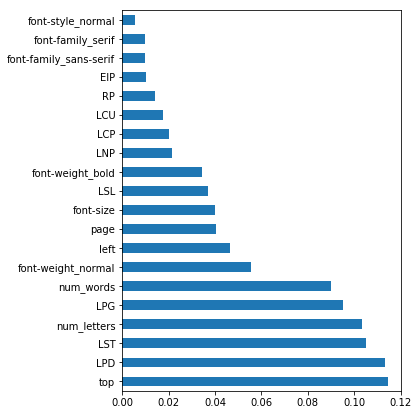

In [201]:
feat_importances = pd.Series(model.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')